<a href="https://colab.research.google.com/github/manyana72/RL-Mario/blob/main/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All required packages are installed.



In [1]:
!pip install gym-super-mario-bros
!apt-get update
!apt-get install ffmpeg libsm6 libxext6  -y
!apt install -y libgl1-mesa-glx
!pip install opencv-python
!pip install ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu

Required libraries are imported.

In [2]:
import torch
import torch.nn as nn
import random
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from tqdm import tqdm
import pickle 
from gym_super_mario_bros.actions import RIGHT_ONLY
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt
from IPython import display

*   The game environment is created here,using OpenAI gym, and NES emulator
*   In order to observe the environment, we have used every 4th image frame, since they provide the enough data, and analysing all consecutive frames is computationally expensive and unnecessary. 
*   The image frames are first grayscaled, and their pixel values are appropriately normalized (converted to size 84*84) for further processing.

In [3]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every 4th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    """
    Downsamples image to 84x84
    Greyscales image

    Returns numpy array
    """
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    """Normalize pixel values in frame --> 0 to 1"""
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


def make_env(env):
    env = MaxAndSkipEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, RIGHT_ONLY)

The DQN Layers are defined here.
*   A CNN network using ReLu is used to process the image frames
*   The hyperparameters are standardized after performing many iterations.
*   The DQN functions such as Remember (to store an experience), Recall( to randomly sample a batch of experiences), Experience_Replay (where the action of updating the q-values for each episode is carried out)

In [4]:
class DQNSolver(nn.Module):

    def __init__(self, input_shape, n_actions):
        super(DQNSolver, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)
    

class DQNAgent:

    def __init__(self, state_space, action_space, max_memory_size, batch_size, gamma, lr,
                 dropout, exploration_max, exploration_min, exploration_decay, double_dq, pretrained):

        # Define DQN Layers
        self.state_space = state_space
        self.action_space = action_space
        self.double_dq = double_dq
        self.pretrained = pretrained
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.dqn = DQNSolver(state_space, action_space).to(self.device)
        if self.pretrained:
            self.dqn.load_state_dict(torch.load("dq.pt", map_location=torch.device(self.device)))
        self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)

        # Create memory
        self.max_memory_size = max_memory_size
        if self.pretrained:
            self.STATE_MEM = torch.load("STATE_MEM.pt")
            self.ACTION_MEM = torch.load("ACTION_MEM.pt")
            self.REWARD_MEM = torch.load("REWARD_MEM.pt")
            self.STATE2_MEM = torch.load("STATE2_MEM.pt")
            self.DONE_MEM = torch.load("DONE_MEM.pt")
            with open("ending_position.pkl", 'rb') as f:
                self.ending_position = pickle.load(f)
            with open("num_in_queue.pkl", 'rb') as f:
                self.num_in_queue = pickle.load(f)
        else:
            self.STATE_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.ACTION_MEM = torch.zeros(max_memory_size, 1)
            self.REWARD_MEM = torch.zeros(max_memory_size, 1)
            self.STATE2_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.DONE_MEM = torch.zeros(max_memory_size, 1)
            self.ending_position = 0
            self.num_in_queue = 0
        
        self.memory_sample_size = batch_size
        
        # Learning parameters
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device) # Also known as Huber loss
        self.exploration_max = exploration_max
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay

    def remember(self, state, action, reward, state2, done):
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)
        
    def recall(self):
        # Randomly sample 'batch size' experiences
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]
        
        return STATE, ACTION, REWARD, STATE2, DONE

    def act(self, state):
        # Epsilon-greedy action
        
        if random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.action_space)]])
        return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()

    def copy_model(self):
        # Copy local net weights into target net
        self.target_net.load_state_dict(self.local_net.state_dict())
    
    def experience_replay(self):

        if self.memory_sample_size > self.num_in_queue:
            return

        STATE, ACTION, REWARD, STATE2, DONE = self.recall()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
        if self.dq:
            # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a) 
            target = REWARD + torch.mul((self.gamma * 
                                        self.dqn(STATE2).max(1).values.unsqueeze(1)), 
                                        1 - DONE)
                
            current = self.dqn(STATE).gather(1, ACTION.long())
        
        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        self.exploration_rate *= self.exploration_decay
        
        # Makes sure that exploration rate is always at least 'exploration min'
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)

In [5]:
def vectorize_action(action, action_space):
    # Given a scalar action, return a one-hot encoded action
    
    return [0 for _ in range(action)] + [1] + [0 for _ in range(action + 1, action_space)]

To display the state.

In [6]:
def show_state(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

The final training of model. After which you can visualize the trained agent playing the game, by changing the required booleans while calling the function at the end.

  0%|          | 1/500 [00:52<7:20:29, 52.96s/it]

Total reward after episode 1 is 998.0


  0%|          | 2/500 [00:59<3:34:08, 25.80s/it]

Total reward after episode 2 is 249.0


  1%|          | 3/500 [01:04<2:14:21, 16.22s/it]

Total reward after episode 3 is 238.0


  1%|          | 4/500 [01:45<3:35:40, 26.09s/it]

Total reward after episode 4 is 1011.0


  1%|          | 5/500 [01:50<2:32:35, 18.50s/it]

Total reward after episode 5 is 244.0


  1%|          | 6/500 [01:55<1:53:35, 13.80s/it]

Total reward after episode 6 is 250.0


  1%|▏         | 7/500 [02:01<1:32:50, 11.30s/it]

Total reward after episode 7 is 249.0


  2%|▏         | 8/500 [02:05<1:14:24,  9.07s/it]

Total reward after episode 8 is 249.0


  2%|▏         | 9/500 [02:10<1:02:13,  7.60s/it]

Total reward after episode 9 is 250.0


  2%|▏         | 10/500 [02:36<1:50:07, 13.48s/it]

Total reward after episode 10 is 631.0


  2%|▏         | 11/500 [02:41<1:27:07, 10.69s/it]

Total reward after episode 11 is 250.0


  2%|▏         | 12/500 [02:46<1:12:04,  8.86s/it]

Total reward after episode 12 is 248.0


  3%|▎         | 13/500 [03:04<1:35:53, 11.81s/it]

Total reward after episode 13 is 614.0


  3%|▎         | 14/500 [03:09<1:17:46,  9.60s/it]

Total reward after episode 14 is 250.0


  3%|▎         | 15/500 [03:21<1:23:16, 10.30s/it]

Total reward after episode 15 is 606.0


  3%|▎         | 16/500 [03:25<1:08:57,  8.55s/it]

Total reward after episode 16 is 250.0


  3%|▎         | 17/500 [03:29<58:57,  7.32s/it]  

Total reward after episode 17 is 249.0


  4%|▎         | 18/500 [03:34<52:10,  6.49s/it]

Total reward after episode 18 is 248.0


  4%|▍         | 19/500 [03:38<47:00,  5.86s/it]

Total reward after episode 19 is 250.0


  4%|▍         | 20/500 [03:43<43:25,  5.43s/it]

Total reward after episode 20 is 250.0


  4%|▍         | 21/500 [03:47<41:11,  5.16s/it]

Total reward after episode 21 is 250.0


  4%|▍         | 22/500 [03:52<39:50,  5.00s/it]

Total reward after episode 22 is 248.0


  5%|▍         | 23/500 [03:57<38:31,  4.85s/it]

Total reward after episode 23 is 250.0


  5%|▍         | 24/500 [04:27<1:39:33, 12.55s/it]

Total reward after episode 24 is 1034.0


  5%|▌         | 25/500 [05:08<2:47:57, 21.22s/it]

Total reward after episode 25 is 593.0


  5%|▌         | 26/500 [05:13<2:08:17, 16.24s/it]

Total reward after episode 26 is 250.0


  5%|▌         | 27/500 [05:18<1:40:34, 12.76s/it]

Total reward after episode 27 is 250.0


  6%|▌         | 28/500 [05:22<1:21:07, 10.31s/it]

Total reward after episode 28 is 250.0


  6%|▌         | 29/500 [05:27<1:07:30,  8.60s/it]

Total reward after episode 29 is 250.0


  6%|▌         | 30/500 [05:32<59:37,  7.61s/it]  

Total reward after episode 30 is 244.0


  6%|▌         | 31/500 [05:37<52:10,  6.67s/it]

Total reward after episode 31 is 250.0


  6%|▋         | 32/500 [05:41<47:00,  6.03s/it]

Total reward after episode 32 is 250.0


  7%|▋         | 33/500 [05:46<43:17,  5.56s/it]

Total reward after episode 33 is 249.0


  7%|▋         | 34/500 [06:09<1:23:18, 10.73s/it]

Total reward after episode 34 is 619.0


  7%|▋         | 35/500 [06:13<1:08:39,  8.86s/it]

Total reward after episode 35 is 250.0


  7%|▋         | 36/500 [06:18<58:31,  7.57s/it]  

Total reward after episode 36 is 251.0


  7%|▋         | 37/500 [06:22<51:15,  6.64s/it]

Total reward after episode 37 is 250.0


  8%|▊         | 38/500 [06:27<46:10,  6.00s/it]

Total reward after episode 38 is 250.0


  8%|▊         | 39/500 [06:31<42:50,  5.58s/it]

Total reward after episode 39 is 250.0


  8%|▊         | 40/500 [06:36<40:07,  5.23s/it]

Total reward after episode 40 is 250.0


  8%|▊         | 41/500 [06:56<1:15:24,  9.86s/it]

Total reward after episode 41 is 612.0


  8%|▊         | 42/500 [07:01<1:04:01,  8.39s/it]

Total reward after episode 42 is 250.0


  9%|▊         | 43/500 [07:06<55:18,  7.26s/it]  

Total reward after episode 43 is 250.0


  9%|▉         | 44/500 [07:10<48:54,  6.44s/it]

Total reward after episode 44 is 250.0


  9%|▉         | 45/500 [07:15<44:26,  5.86s/it]

Total reward after episode 45 is 250.0


  9%|▉         | 46/500 [07:19<41:08,  5.44s/it]

Total reward after episode 46 is 250.0


  9%|▉         | 47/500 [07:24<38:52,  5.15s/it]

Total reward after episode 47 is 250.0


 10%|▉         | 48/500 [07:29<38:01,  5.05s/it]

Total reward after episode 48 is 244.0


 10%|▉         | 49/500 [07:33<36:58,  4.92s/it]

Total reward after episode 49 is 248.0


 10%|█         | 50/500 [07:37<35:08,  4.69s/it]

Total reward after episode 50 is 247.0


 10%|█         | 51/500 [07:49<50:12,  6.71s/it]

Total reward after episode 51 is 610.0


 10%|█         | 52/500 [07:54<46:45,  6.26s/it]

Total reward after episode 52 is 244.0


 11%|█         | 53/500 [07:59<42:46,  5.74s/it]

Total reward after episode 53 is 250.0


 11%|█         | 54/500 [08:39<2:00:14, 16.18s/it]

Total reward after episode 54 is 1322.0


 11%|█         | 55/500 [12:07<9:06:18, 73.66s/it]

Total reward after episode 55 is 374.0


 11%|█         | 56/500 [12:28<7:08:21, 57.89s/it]

Total reward after episode 56 is 618.0


 11%|█▏        | 57/500 [12:32<5:08:58, 41.85s/it]

Total reward after episode 57 is 248.0


 12%|█▏        | 58/500 [12:37<3:45:03, 30.55s/it]

Total reward after episode 58 is 248.0


 12%|█▏        | 59/500 [12:41<2:46:24, 22.64s/it]

Total reward after episode 59 is 248.0


 12%|█▏        | 60/500 [14:26<5:48:38, 47.54s/it]

Total reward after episode 60 is 505.0


 12%|█▏        | 61/500 [14:31<4:13:43, 34.68s/it]

Total reward after episode 61 is 241.0


 12%|█▏        | 62/500 [14:36<3:07:37, 25.70s/it]

Total reward after episode 62 is 239.0


 13%|█▎        | 63/500 [14:41<2:21:30, 19.43s/it]

Total reward after episode 63 is 239.0


 13%|█▎        | 64/500 [14:45<1:49:15, 15.04s/it]

Total reward after episode 64 is 239.0


 13%|█▎        | 65/500 [14:50<1:26:42, 11.96s/it]

Total reward after episode 65 is 239.0


 13%|█▎        | 66/500 [14:55<1:10:56,  9.81s/it]

Total reward after episode 66 is 237.0


 13%|█▎        | 67/500 [14:59<59:25,  8.23s/it]  

Total reward after episode 67 is 238.0


 14%|█▎        | 68/500 [15:04<52:11,  7.25s/it]

Total reward after episode 68 is 243.0


 14%|█▍        | 69/500 [15:09<45:29,  6.33s/it]

Total reward after episode 69 is 248.0


 14%|█▍        | 70/500 [15:20<56:44,  7.92s/it]

Total reward after episode 70 is 632.0


 14%|█▍        | 71/500 [15:24<48:37,  6.80s/it]

Total reward after episode 71 is 248.0


 14%|█▍        | 72/500 [15:29<42:55,  6.02s/it]

Total reward after episode 72 is 248.0


 15%|█▍        | 73/500 [15:33<40:17,  5.66s/it]

Total reward after episode 73 is 239.0


 15%|█▍        | 74/500 [15:38<37:19,  5.26s/it]

Total reward after episode 74 is 249.0


 15%|█▌        | 75/500 [15:42<34:56,  4.93s/it]

Total reward after episode 75 is 248.0


 15%|█▌        | 76/500 [15:47<34:49,  4.93s/it]

Total reward after episode 76 is 238.0


 15%|█▌        | 77/500 [15:51<33:36,  4.77s/it]

Total reward after episode 77 is 248.0


 16%|█▌        | 78/500 [15:56<32:28,  4.62s/it]

Total reward after episode 78 is 248.0


 16%|█▌        | 79/500 [16:00<32:31,  4.64s/it]

Total reward after episode 79 is 239.0


 16%|█▌        | 80/500 [16:05<31:54,  4.56s/it]

Total reward after episode 80 is 248.0


 16%|█▌        | 81/500 [16:09<32:19,  4.63s/it]

Total reward after episode 81 is 239.0


 16%|█▋        | 82/500 [17:40<3:32:55, 30.56s/it]

Total reward after episode 82 is 722.0


 17%|█▋        | 83/500 [18:27<4:06:44, 35.50s/it]

Total reward after episode 83 is 557.0


 17%|█▋        | 84/500 [19:31<5:04:26, 43.91s/it]

Total reward after episode 84 is 548.0


 17%|█▋        | 85/500 [19:52<4:16:31, 37.09s/it]

Total reward after episode 85 is 639.0


 17%|█▋        | 86/500 [20:03<3:21:06, 29.15s/it]

Total reward after episode 86 is 634.0


 17%|█▋        | 87/500 [20:08<2:30:20, 21.84s/it]

Total reward after episode 87 is 238.0


 18%|█▊        | 88/500 [20:12<1:53:39, 16.55s/it]

Total reward after episode 88 is 248.0


 18%|█▊        | 89/500 [20:17<1:29:30, 13.07s/it]

Total reward after episode 89 is 238.0


 18%|█▊        | 90/500 [20:22<1:12:22, 10.59s/it]

Total reward after episode 90 is 239.0


 18%|█▊        | 91/500 [20:39<1:27:03, 12.77s/it]

Total reward after episode 91 is 600.0


 18%|█▊        | 92/500 [20:52<1:25:38, 12.60s/it]

Total reward after episode 92 is 611.0


 19%|█▊        | 93/500 [21:01<1:19:40, 11.75s/it]

Total reward after episode 93 is 604.0


 19%|█▉        | 94/500 [21:21<1:35:58, 14.18s/it]

Total reward after episode 94 is 817.0


 19%|█▉        | 95/500 [21:50<2:04:32, 18.45s/it]

Total reward after episode 95 is 806.0


 19%|█▉        | 96/500 [22:01<1:49:02, 16.19s/it]

Total reward after episode 96 is 607.0


 19%|█▉        | 97/500 [22:19<1:53:58, 16.97s/it]

Total reward after episode 97 is 600.0


 20%|█▉        | 98/500 [22:24<1:29:53, 13.42s/it]

Total reward after episode 98 is 239.0


 20%|█▉        | 99/500 [22:39<1:31:16, 13.66s/it]

Total reward after episode 99 is 603.0


 20%|██        | 100/500 [22:51<1:28:00, 13.20s/it]

Total reward after episode 100 is 633.0


 20%|██        | 101/500 [23:00<1:20:00, 12.03s/it]

Total reward after episode 101 is 610.0


 20%|██        | 102/500 [25:13<5:19:43, 48.20s/it]

Total reward after episode 102 is 670.0


 21%|██        | 103/500 [25:39<4:35:16, 41.60s/it]

Total reward after episode 103 is 809.0


 21%|██        | 104/500 [26:17<4:27:26, 40.52s/it]

Total reward after episode 104 is 793.0


 21%|██        | 105/500 [26:33<3:37:47, 33.08s/it]

Total reward after episode 105 is 601.0


 21%|██        | 106/500 [27:10<3:45:57, 34.41s/it]

Total reward after episode 106 is 794.0


 21%|██▏       | 107/500 [27:41<3:38:09, 33.31s/it]

Total reward after episode 107 is 1032.0


 22%|██▏       | 108/500 [28:10<3:29:43, 32.10s/it]

Total reward after episode 108 is 804.0


 22%|██▏       | 109/500 [28:24<2:52:56, 26.54s/it]

Total reward after episode 109 is 622.0


 22%|██▏       | 110/500 [29:13<3:35:57, 33.23s/it]

Total reward after episode 110 is 779.0


 22%|██▏       | 111/500 [29:24<2:53:07, 26.70s/it]

Total reward after episode 111 is 605.0


 22%|██▏       | 112/500 [29:59<3:08:42, 29.18s/it]

Total reward after episode 112 is 1329.0


 23%|██▎       | 113/500 [30:03<2:19:55, 21.69s/it]

Total reward after episode 113 is 248.0


 23%|██▎       | 114/500 [30:17<2:03:43, 19.23s/it]

Total reward after episode 114 is 624.0


 23%|██▎       | 115/500 [30:22<1:35:41, 14.91s/it]

Total reward after episode 115 is 247.0


 23%|██▎       | 116/500 [30:26<1:15:26, 11.79s/it]

Total reward after episode 116 is 250.0


 23%|██▎       | 117/500 [30:31<1:01:19,  9.61s/it]

Total reward after episode 117 is 250.0


 24%|██▎       | 118/500 [30:35<52:04,  8.18s/it]  

Total reward after episode 118 is 252.0


 24%|██▍       | 119/500 [30:40<45:01,  7.09s/it]

Total reward after episode 119 is 249.0


 24%|██▍       | 120/500 [30:44<39:32,  6.24s/it]

Total reward after episode 120 is 247.0


 24%|██▍       | 121/500 [30:49<35:51,  5.68s/it]

Total reward after episode 121 is 248.0


 24%|██▍       | 122/500 [30:53<33:57,  5.39s/it]

Total reward after episode 122 is 246.0


 25%|██▍       | 123/500 [31:19<1:12:52, 11.60s/it]

Total reward after episode 123 is 1343.0


 25%|██▍       | 124/500 [31:24<59:19,  9.47s/it]  

Total reward after episode 124 is 245.0


 25%|██▌       | 125/500 [31:29<51:09,  8.19s/it]

Total reward after episode 125 is 235.0


 25%|██▌       | 126/500 [32:01<1:34:36, 15.18s/it]

Total reward after episode 126 is 626.0


 25%|██▌       | 127/500 [33:12<3:19:31, 32.09s/it]

Total reward after episode 127 is 559.0


 26%|██▌       | 128/500 [33:52<3:34:16, 34.56s/it]

Total reward after episode 128 is 1324.0


 26%|██▌       | 129/500 [34:09<3:00:16, 29.16s/it]

Total reward after episode 129 is 629.0


 26%|██▌       | 130/500 [34:38<2:59:32, 29.11s/it]

Total reward after episode 130 is 1339.0


 26%|██▌       | 131/500 [35:00<2:45:22, 26.89s/it]

Total reward after episode 131 is 595.0


 26%|██▋       | 132/500 [35:12<2:18:52, 22.64s/it]

Total reward after episode 132 is 651.0


 27%|██▋       | 133/500 [35:17<1:44:35, 17.10s/it]

Total reward after episode 133 is 248.0


 27%|██▋       | 134/500 [35:30<1:38:04, 16.08s/it]

Total reward after episode 134 is 631.0


 27%|██▋       | 135/500 [36:00<2:01:58, 20.05s/it]

Total reward after episode 135 is 1338.0


 27%|██▋       | 136/500 [36:15<1:52:52, 18.61s/it]

Total reward after episode 136 is 624.0


 27%|██▋       | 137/500 [37:22<3:19:45, 33.02s/it]

Total reward after episode 137 is 1289.0


 28%|██▊       | 138/500 [38:14<3:55:16, 39.00s/it]

Total reward after episode 138 is 1310.0


 28%|██▊       | 139/500 [38:28<3:08:32, 31.34s/it]

Total reward after episode 139 is 623.0


 28%|██▊       | 140/500 [38:32<2:19:19, 23.22s/it]

Total reward after episode 140 is 244.0


 28%|██▊       | 141/500 [38:37<1:45:17, 17.60s/it]

Total reward after episode 141 is 245.0


 28%|██▊       | 142/500 [38:41<1:21:11, 13.61s/it]

Total reward after episode 142 is 249.0


 29%|██▊       | 143/500 [38:45<1:04:27, 10.83s/it]

Total reward after episode 143 is 248.0


 29%|██▉       | 144/500 [38:50<52:42,  8.88s/it]  

Total reward after episode 144 is 249.0


 29%|██▉       | 145/500 [38:54<44:12,  7.47s/it]

Total reward after episode 145 is 248.0


 29%|██▉       | 146/500 [38:58<39:01,  6.61s/it]

Total reward after episode 146 is 240.0


 29%|██▉       | 147/500 [39:25<1:13:44, 12.53s/it]

Total reward after episode 147 is 1340.0


 30%|██▉       | 148/500 [39:56<1:46:35, 18.17s/it]

Total reward after episode 148 is 625.0


 30%|██▉       | 149/500 [40:00<1:21:54, 14.00s/it]

Total reward after episode 149 is 244.0


 30%|███       | 150/500 [40:19<1:29:12, 15.29s/it]

Total reward after episode 150 is 602.0


 30%|███       | 151/500 [40:59<2:12:52, 22.84s/it]

Total reward after episode 151 is 1119.0


 30%|███       | 152/500 [41:04<1:40:36, 17.35s/it]

Total reward after episode 152 is 250.0


 31%|███       | 153/500 [41:08<1:18:18, 13.54s/it]

Total reward after episode 153 is 247.0


 31%|███       | 154/500 [41:13<1:03:08, 10.95s/it]

Total reward after episode 154 is 236.0


 31%|███       | 155/500 [41:41<1:31:36, 15.93s/it]

Total reward after episode 155 is 734.0


 31%|███       | 156/500 [41:46<1:12:32, 12.65s/it]

Total reward after episode 156 is 236.0


 31%|███▏      | 157/500 [41:50<58:12, 10.18s/it]  

Total reward after episode 157 is 250.0


 32%|███▏      | 158/500 [41:55<49:04,  8.61s/it]

Total reward after episode 158 is 235.0


 32%|███▏      | 159/500 [42:34<1:40:16, 17.64s/it]

Total reward after episode 159 is 733.0


 32%|███▏      | 160/500 [42:58<1:51:00, 19.59s/it]

Total reward after episode 160 is 812.0


 32%|███▏      | 161/500 [43:02<1:25:03, 15.06s/it]

Total reward after episode 161 is 246.0


 32%|███▏      | 162/500 [43:07<1:06:37, 11.83s/it]

Total reward after episode 162 is 248.0


 33%|███▎      | 163/500 [43:11<53:57,  9.61s/it]  

Total reward after episode 163 is 248.0


 33%|███▎      | 164/500 [43:45<1:34:53, 16.94s/it]

Total reward after episode 164 is 1331.0


 33%|███▎      | 165/500 [44:27<2:16:38, 24.47s/it]

Total reward after episode 165 is 591.0


 33%|███▎      | 166/500 [45:18<3:00:29, 32.42s/it]

Total reward after episode 166 is 776.0


 33%|███▎      | 167/500 [45:23<2:13:12, 24.00s/it]

Total reward after episode 167 is 248.0


 34%|███▎      | 168/500 [46:00<2:35:07, 28.03s/it]

Total reward after episode 168 is 1023.0


 34%|███▍      | 169/500 [46:15<2:13:01, 24.11s/it]

Total reward after episode 169 is 634.0


 34%|███▍      | 170/500 [46:20<1:40:39, 18.30s/it]

Total reward after episode 170 is 243.0


 34%|███▍      | 171/500 [47:21<2:51:37, 31.30s/it]

Total reward after episode 171 is 569.0


 34%|███▍      | 172/500 [48:46<4:17:51, 47.17s/it]

Total reward after episode 172 is 1263.0


 35%|███▍      | 173/500 [49:35<4:20:04, 47.72s/it]

Total reward after episode 173 is 588.0


 35%|███▍      | 174/500 [49:53<3:31:50, 38.99s/it]

Total reward after episode 174 is 630.0


 35%|███▌      | 175/500 [49:57<2:34:31, 28.53s/it]

Total reward after episode 175 is 251.0


 35%|███▌      | 176/500 [50:10<2:08:09, 23.73s/it]

Total reward after episode 176 is 623.0


 35%|███▌      | 177/500 [50:54<2:40:58, 29.90s/it]

Total reward after episode 177 is 561.0


 36%|███▌      | 178/500 [51:57<3:33:16, 39.74s/it]

Total reward after episode 178 is 548.0


 36%|███▌      | 179/500 [52:10<2:49:41, 31.72s/it]

Total reward after episode 179 is 610.0


 36%|███▌      | 180/500 [53:00<3:18:25, 37.21s/it]

Total reward after episode 180 is 600.0


 36%|███▌      | 181/500 [53:13<2:38:50, 29.87s/it]

Total reward after episode 181 is 618.0


 36%|███▋      | 182/500 [53:50<2:50:48, 32.23s/it]

Total reward after episode 182 is 1325.0


 37%|███▋      | 183/500 [53:55<2:06:12, 23.89s/it]

Total reward after episode 183 is 250.0


 37%|███▋      | 184/500 [53:59<1:34:36, 17.96s/it]

Total reward after episode 184 is 248.0


 37%|███▋      | 185/500 [54:42<2:13:27, 25.42s/it]

Total reward after episode 185 is 1118.0


 37%|███▋      | 186/500 [54:46<1:40:06, 19.13s/it]

Total reward after episode 186 is 250.0


 37%|███▋      | 187/500 [54:50<1:16:24, 14.65s/it]

Total reward after episode 187 is 248.0


 38%|███▊      | 188/500 [54:55<1:00:08, 11.56s/it]

Total reward after episode 188 is 248.0


 38%|███▊      | 189/500 [55:00<49:48,  9.61s/it]  

Total reward after episode 189 is 238.0


 38%|███▊      | 190/500 [55:30<1:21:57, 15.86s/it]

Total reward after episode 190 is 627.0


 38%|███▊      | 191/500 [55:35<1:04:17, 12.48s/it]

Total reward after episode 191 is 240.0


 38%|███▊      | 192/500 [55:39<51:35, 10.05s/it]  

Total reward after episode 192 is 248.0


 39%|███▊      | 193/500 [56:11<1:24:53, 16.59s/it]

Total reward after episode 193 is 593.0


 39%|███▉      | 194/500 [56:28<1:25:05, 16.68s/it]

Total reward after episode 194 is 626.0


 39%|███▉      | 195/500 [56:52<1:36:38, 19.01s/it]

Total reward after episode 195 is 1344.0


 39%|███▉      | 196/500 [56:57<1:13:59, 14.60s/it]

Total reward after episode 196 is 244.0


 39%|███▉      | 197/500 [57:01<58:11, 11.52s/it]  

Total reward after episode 197 is 249.0


 40%|███▉      | 198/500 [57:30<1:23:34, 16.60s/it]

Total reward after episode 198 is 1034.0


 40%|███▉      | 199/500 [57:46<1:22:43, 16.49s/it]

Total reward after episode 199 is 604.0


 40%|████      | 200/500 [57:57<1:14:11, 14.84s/it]

Total reward after episode 200 is 640.0


 40%|████      | 201/500 [58:36<1:50:00, 22.08s/it]

Total reward after episode 201 is 1323.0


 40%|████      | 202/500 [58:40<1:23:13, 16.76s/it]

Total reward after episode 202 is 249.0


 41%|████      | 203/500 [58:45<1:04:57, 13.12s/it]

Total reward after episode 203 is 240.0


 41%|████      | 204/500 [58:49<52:04, 10.56s/it]  

Total reward after episode 204 is 246.0


 41%|████      | 205/500 [58:54<42:38,  8.67s/it]

Total reward after episode 205 is 251.0


 41%|████      | 206/500 [58:58<36:32,  7.46s/it]

Total reward after episode 206 is 240.0


 41%|████▏     | 207/500 [59:10<43:21,  8.88s/it]

Total reward after episode 207 is 651.0


 42%|████▏     | 208/500 [1:00:04<1:48:57, 22.39s/it]

Total reward after episode 208 is 1099.0


 42%|████▏     | 209/500 [1:00:19<1:36:59, 20.00s/it]

Total reward after episode 209 is 632.0


 42%|████▏     | 210/500 [1:00:43<1:42:38, 21.24s/it]

Total reward after episode 210 is 1439.0


 42%|████▏     | 211/500 [1:01:12<1:53:46, 23.62s/it]

Total reward after episode 211 is 764.0


 42%|████▏     | 212/500 [1:01:35<1:51:56, 23.32s/it]

Total reward after episode 212 is 637.0


 43%|████▎     | 213/500 [1:01:39<1:24:16, 17.62s/it]

Total reward after episode 213 is 248.0


 43%|████▎     | 214/500 [1:02:58<2:52:26, 36.18s/it]

Total reward after episode 214 is 1269.0


 43%|████▎     | 215/500 [1:03:26<2:39:50, 33.65s/it]

Total reward after episode 215 is 630.0


 43%|████▎     | 216/500 [1:04:31<3:23:59, 43.10s/it]

Total reward after episode 216 is 1290.0


 43%|████▎     | 217/500 [1:04:36<2:28:16, 31.44s/it]

Total reward after episode 217 is 249.0


 44%|████▎     | 218/500 [1:05:54<3:33:20, 45.39s/it]

Total reward after episode 218 is 1071.0


 44%|████▍     | 219/500 [1:06:34<3:26:04, 44.00s/it]

Total reward after episode 219 is 791.0


 44%|████▍     | 220/500 [1:06:39<2:30:19, 32.21s/it]

Total reward after episode 220 is 250.0


 44%|████▍     | 221/500 [1:06:44<1:51:37, 24.01s/it]

Total reward after episode 221 is 244.0


 44%|████▍     | 222/500 [1:06:53<1:30:31, 19.54s/it]

Total reward after episode 222 is 609.0


 45%|████▍     | 223/500 [1:07:42<2:11:23, 28.46s/it]

Total reward after episode 223 is 1395.0


 45%|████▍     | 224/500 [1:08:56<3:13:32, 42.07s/it]

Total reward after episode 224 is 1280.0


 45%|████▌     | 225/500 [1:09:42<3:17:34, 43.11s/it]

Total reward after episode 225 is 576.0


 45%|████▌     | 226/500 [1:09:48<2:26:01, 31.98s/it]

Total reward after episode 226 is 223.0


 45%|████▌     | 227/500 [1:09:53<1:48:31, 23.85s/it]

Total reward after episode 227 is 239.0


 46%|████▌     | 228/500 [1:10:06<1:33:49, 20.70s/it]

Total reward after episode 228 is 632.0


 46%|████▌     | 229/500 [1:10:37<1:47:56, 23.90s/it]

Total reward after episode 229 is 802.0


 46%|████▌     | 230/500 [1:11:17<2:09:32, 28.79s/it]

Total reward after episode 230 is 791.0


 46%|████▌     | 231/500 [1:12:09<2:39:22, 35.55s/it]

Total reward after episode 231 is 1310.0


 46%|████▋     | 232/500 [1:12:41<2:34:53, 34.68s/it]

Total reward after episode 232 is 1334.0


 47%|████▋     | 233/500 [1:12:46<1:54:09, 25.65s/it]

Total reward after episode 233 is 251.0


 47%|████▋     | 234/500 [1:13:36<2:25:49, 32.89s/it]

Total reward after episode 234 is 588.0


 47%|████▋     | 235/500 [1:14:25<2:46:44, 37.75s/it]

Total reward after episode 235 is 1313.0


 47%|████▋     | 236/500 [1:14:29<2:02:19, 27.80s/it]

Total reward after episode 236 is 253.0


 47%|████▋     | 237/500 [1:14:34<1:31:19, 20.83s/it]

Total reward after episode 237 is 249.0


 48%|████▊     | 238/500 [1:15:19<2:03:01, 28.17s/it]

Total reward after episode 238 is 608.0


 48%|████▊     | 239/500 [1:15:30<1:39:44, 22.93s/it]

Total reward after episode 239 is 653.0


 48%|████▊     | 240/500 [1:15:35<1:15:25, 17.41s/it]

Total reward after episode 240 is 251.0


 48%|████▊     | 241/500 [1:16:21<1:52:57, 26.17s/it]

Total reward after episode 241 is 1404.0


 48%|████▊     | 242/500 [1:16:29<1:29:18, 20.77s/it]

Total reward after episode 242 is 180.0


 49%|████▊     | 243/500 [1:17:00<1:41:50, 23.78s/it]

Total reward after episode 243 is 627.0


 49%|████▉     | 244/500 [1:17:46<2:09:19, 30.31s/it]

Total reward after episode 244 is 608.0


 49%|████▉     | 245/500 [1:17:50<1:35:49, 22.55s/it]

Total reward after episode 245 is 247.0


 49%|████▉     | 246/500 [1:17:55<1:12:26, 17.11s/it]

Total reward after episode 246 is 248.0


 49%|████▉     | 247/500 [1:17:59<56:05, 13.30s/it]  

Total reward after episode 247 is 248.0


 50%|████▉     | 248/500 [1:18:07<49:38, 11.82s/it]

Total reward after episode 248 is 177.0


 50%|████▉     | 249/500 [1:18:41<1:17:05, 18.43s/it]

Total reward after episode 249 is 1423.0


 50%|█████     | 250/500 [1:19:01<1:18:48, 18.92s/it]

Total reward after episode 250 is 624.0


 50%|█████     | 251/500 [1:19:35<1:36:37, 23.28s/it]

Total reward after episode 251 is 1333.0


 50%|█████     | 252/500 [1:19:59<1:36:57, 23.46s/it]

Total reward after episode 252 is 614.0


 51%|█████     | 253/500 [1:20:23<1:38:23, 23.90s/it]

Total reward after episode 253 is 745.0


 51%|█████     | 254/500 [1:20:48<1:38:28, 24.02s/it]

Total reward after episode 254 is 598.0


 51%|█████     | 255/500 [1:20:56<1:18:46, 19.29s/it]

Total reward after episode 255 is 184.0


 51%|█████     | 256/500 [1:21:00<59:54, 14.73s/it]  

Total reward after episode 256 is 252.0


 51%|█████▏    | 257/500 [1:21:30<1:17:53, 19.23s/it]

Total reward after episode 257 is 804.0


 52%|█████▏    | 258/500 [1:21:53<1:21:44, 20.27s/it]

Total reward after episode 258 is 618.0


 52%|█████▏    | 259/500 [1:22:05<1:11:31, 17.81s/it]

Total reward after episode 259 is 628.0


 52%|█████▏    | 260/500 [1:22:43<1:36:09, 24.04s/it]

Total reward after episode 260 is 581.0


 52%|█████▏    | 261/500 [1:23:41<2:15:52, 34.11s/it]

Total reward after episode 261 is 593.0


 52%|█████▏    | 262/500 [1:23:55<1:51:13, 28.04s/it]

Total reward after episode 262 is 622.0


 53%|█████▎    | 263/500 [1:24:15<1:41:51, 25.79s/it]

Total reward after episode 263 is 615.0


 53%|█████▎    | 264/500 [1:25:09<2:14:02, 34.08s/it]

Total reward after episode 264 is 772.0


 53%|█████▎    | 265/500 [1:25:22<1:49:21, 27.92s/it]

Total reward after episode 265 is 605.0


 53%|█████▎    | 266/500 [1:26:06<2:07:36, 32.72s/it]

Total reward after episode 266 is 1404.0


 53%|█████▎    | 267/500 [1:26:43<2:12:23, 34.09s/it]

Total reward after episode 267 is 604.0


 54%|█████▎    | 268/500 [1:27:24<2:19:59, 36.20s/it]

Total reward after episode 268 is 1017.0


 54%|█████▍    | 269/500 [1:27:29<1:42:54, 26.73s/it]

Total reward after episode 269 is 252.0


 54%|█████▍    | 270/500 [1:27:49<1:34:50, 24.74s/it]

Total reward after episode 270 is 817.0


 54%|█████▍    | 271/500 [1:28:20<1:41:53, 26.70s/it]

Total reward after episode 271 is 802.0


 54%|█████▍    | 272/500 [1:28:46<1:39:39, 26.22s/it]

Total reward after episode 272 is 1434.0


 55%|█████▍    | 273/500 [1:29:07<1:34:02, 24.86s/it]

Total reward after episode 273 is 1347.0


 55%|█████▍    | 274/500 [1:29:12<1:10:33, 18.73s/it]

Total reward after episode 274 is 251.0


 55%|█████▌    | 275/500 [1:29:35<1:15:54, 20.24s/it]

Total reward after episode 275 is 1346.0


 55%|█████▌    | 276/500 [1:29:47<1:05:45, 17.61s/it]

Total reward after episode 276 is 609.0


 55%|█████▌    | 277/500 [1:30:14<1:15:29, 20.31s/it]

Total reward after episode 277 is 808.0


 56%|█████▌    | 278/500 [1:30:39<1:20:55, 21.87s/it]

Total reward after episode 278 is 809.0


 56%|█████▌    | 279/500 [1:31:05<1:24:44, 23.01s/it]

Total reward after episode 279 is 1344.0


 56%|█████▌    | 280/500 [1:32:41<2:44:35, 44.89s/it]

Total reward after episode 280 is 1339.0


 56%|█████▌    | 281/500 [1:33:03<2:19:36, 38.25s/it]

Total reward after episode 281 is 597.0


 56%|█████▋    | 282/500 [1:33:09<1:42:55, 28.33s/it]

Total reward after episode 282 is 240.0


 57%|█████▋    | 283/500 [1:33:13<1:16:52, 21.26s/it]

Total reward after episode 283 is 250.0


 57%|█████▋    | 284/500 [1:36:41<4:37:35, 77.11s/it]

Total reward after episode 284 is 396.0


 57%|█████▋    | 285/500 [1:36:55<3:29:00, 58.33s/it]

Total reward after episode 285 is 648.0


 57%|█████▋    | 286/500 [1:37:51<3:25:38, 57.66s/it]

Total reward after episode 286 is 1397.0


 57%|█████▋    | 287/500 [1:38:06<2:38:54, 44.76s/it]

Total reward after episode 287 is 622.0


 58%|█████▊    | 288/500 [1:38:41<2:27:34, 41.77s/it]

Total reward after episode 288 is 798.0


 58%|█████▊    | 289/500 [1:39:12<2:15:41, 38.59s/it]

Total reward after episode 289 is 627.0


 58%|█████▊    | 290/500 [1:39:17<1:39:34, 28.45s/it]

Total reward after episode 290 is 250.0


 58%|█████▊    | 291/500 [1:39:29<1:22:21, 23.64s/it]

Total reward after episode 291 is 634.0


 58%|█████▊    | 292/500 [1:39:35<1:02:55, 18.15s/it]

Total reward after episode 292 is 238.0


 59%|█████▊    | 293/500 [1:40:16<1:26:29, 25.07s/it]

Total reward after episode 293 is 1323.0


 59%|█████▉    | 294/500 [1:40:41<1:26:15, 25.13s/it]

Total reward after episode 294 is 1345.0


 59%|█████▉    | 295/500 [1:40:46<1:05:00, 19.03s/it]

Total reward after episode 295 is 252.0


 59%|█████▉    | 296/500 [1:41:07<1:06:28, 19.55s/it]

Total reward after episode 296 is 816.0


 59%|█████▉    | 297/500 [1:42:07<1:47:33, 31.79s/it]

Total reward after episode 297 is 697.0


 60%|█████▉    | 298/500 [1:42:45<1:53:24, 33.68s/it]

Total reward after episode 298 is 1422.0


 60%|█████▉    | 299/500 [1:42:57<1:31:07, 27.20s/it]

Total reward after episode 299 is 621.0


 60%|██████    | 300/500 [1:43:19<1:25:23, 25.62s/it]

Total reward after episode 300 is 613.0


 60%|██████    | 301/500 [1:43:24<1:04:15, 19.38s/it]

Total reward after episode 301 is 247.0


 60%|██████    | 302/500 [1:43:58<1:18:23, 23.75s/it]

Total reward after episode 302 is 724.0


 61%|██████    | 303/500 [1:44:28<1:24:22, 25.70s/it]

Total reward after episode 303 is 1138.0


 61%|██████    | 304/500 [1:45:23<1:53:03, 34.61s/it]

Total reward after episode 304 is 1305.0


 61%|██████    | 305/500 [1:45:41<1:35:42, 29.45s/it]

Total reward after episode 305 is 629.0


 61%|██████    | 306/500 [1:46:02<1:27:13, 26.98s/it]

Total reward after episode 306 is 816.0


 61%|██████▏   | 307/500 [1:46:39<1:36:24, 29.97s/it]

Total reward after episode 307 is 1329.0


 62%|██████▏   | 308/500 [1:47:09<1:35:54, 29.97s/it]

Total reward after episode 308 is 769.0


 62%|██████▏   | 309/500 [1:47:34<1:30:56, 28.57s/it]

Total reward after episode 309 is 1433.0


 62%|██████▏   | 310/500 [1:47:39<1:08:08, 21.52s/it]

Total reward after episode 310 is 240.0


 62%|██████▏   | 311/500 [1:47:44<51:52, 16.47s/it]  

Total reward after episode 311 is 250.0


 62%|██████▏   | 312/500 [1:48:04<54:22, 17.35s/it]

Total reward after episode 312 is 621.0


 63%|██████▎   | 313/500 [1:48:34<1:06:08, 21.22s/it]

Total reward after episode 313 is 609.0


 63%|██████▎   | 314/500 [1:49:39<1:46:43, 34.43s/it]

Total reward after episode 314 is 760.0


 63%|██████▎   | 315/500 [1:50:06<1:38:50, 32.06s/it]

Total reward after episode 315 is 750.0


 63%|██████▎   | 316/500 [1:50:16<1:18:30, 25.60s/it]

Total reward after episode 316 is 624.0


 63%|██████▎   | 317/500 [1:50:30<1:07:37, 22.17s/it]

Total reward after episode 317 is 607.0


 64%|██████▎   | 318/500 [1:51:01<1:15:08, 24.77s/it]

Total reward after episode 318 is 809.0


 64%|██████▍   | 319/500 [1:51:25<1:14:09, 24.58s/it]

Total reward after episode 319 is 646.0


 64%|██████▍   | 320/500 [1:52:06<1:28:21, 29.45s/it]

Total reward after episode 320 is 209.0


 64%|██████▍   | 321/500 [1:52:21<1:15:20, 25.26s/it]

Total reward after episode 321 is 625.0


 64%|██████▍   | 322/500 [1:52:35<1:04:31, 21.75s/it]

Total reward after episode 322 is 637.0


 65%|██████▍   | 323/500 [1:52:40<49:27, 16.76s/it]  

Total reward after episode 323 is 248.0


 65%|██████▍   | 324/500 [1:53:14<1:04:29, 21.99s/it]

Total reward after episode 324 is 578.0


 65%|██████▌   | 325/500 [1:53:31<59:35, 20.43s/it]  

Total reward after episode 325 is 647.0


 65%|██████▌   | 326/500 [1:53:44<52:19, 18.04s/it]

Total reward after episode 326 is 636.0


 65%|██████▌   | 327/500 [1:54:04<53:53, 18.69s/it]

Total reward after episode 327 is 818.0


 66%|██████▌   | 328/500 [1:54:09<42:01, 14.66s/it]

Total reward after episode 328 is 240.0


 66%|██████▌   | 329/500 [1:54:42<57:22, 20.13s/it]

Total reward after episode 329 is 802.0


 66%|██████▌   | 330/500 [1:55:41<1:29:53, 31.72s/it]

Total reward after episode 330 is 1302.0


 66%|██████▌   | 331/500 [1:56:27<1:41:35, 36.07s/it]

Total reward after episode 331 is 589.0


 66%|██████▋   | 332/500 [1:56:32<1:15:17, 26.89s/it]

Total reward after episode 332 is 242.0


 67%|██████▋   | 333/500 [1:57:08<1:21:50, 29.40s/it]

Total reward after episode 333 is 802.0


 67%|██████▋   | 334/500 [1:58:19<1:56:29, 42.11s/it]

Total reward after episode 334 is 753.0


 67%|██████▋   | 335/500 [1:58:24<1:24:37, 30.77s/it]

Total reward after episode 335 is 248.0


 67%|██████▋   | 336/500 [1:58:48<1:19:07, 28.95s/it]

Total reward after episode 336 is 1042.0


 67%|██████▋   | 337/500 [1:59:25<1:24:57, 31.27s/it]

Total reward after episode 337 is 798.0


 68%|██████▊   | 338/500 [1:59:30<1:02:57, 23.32s/it]

Total reward after episode 338 is 249.0


 68%|██████▊   | 339/500 [2:00:19<1:23:09, 30.99s/it]

Total reward after episode 339 is 1031.0


 68%|██████▊   | 340/500 [2:01:18<1:45:23, 39.52s/it]

Total reward after episode 340 is 1304.0


 68%|██████▊   | 341/500 [2:01:23<1:17:02, 29.07s/it]

Total reward after episode 341 is 248.0


 68%|██████▊   | 342/500 [2:02:21<1:39:10, 37.66s/it]

Total reward after episode 342 is 570.0


 69%|██████▊   | 343/500 [2:02:26<1:12:51, 27.84s/it]

Total reward after episode 343 is 246.0


 69%|██████▉   | 344/500 [2:02:37<59:37, 22.93s/it]  

Total reward after episode 344 is 617.0


 69%|██████▉   | 345/500 [2:02:42<45:18, 17.54s/it]

Total reward after episode 345 is 250.0


 69%|██████▉   | 346/500 [2:02:46<34:49, 13.56s/it]

Total reward after episode 346 is 252.0


 69%|██████▉   | 347/500 [2:02:51<27:30, 10.79s/it]

Total reward after episode 347 is 252.0


 70%|██████▉   | 348/500 [2:03:04<29:29, 11.64s/it]

Total reward after episode 348 is 618.0


 70%|██████▉   | 349/500 [2:03:35<43:54, 17.45s/it]

Total reward after episode 349 is 1138.0


 70%|███████   | 350/500 [2:03:51<42:02, 16.82s/it]

Total reward after episode 350 is 648.0


 70%|███████   | 351/500 [2:04:44<1:08:51, 27.73s/it]

Total reward after episode 351 is 777.0


 70%|███████   | 352/500 [2:04:49<51:57, 21.06s/it]  

Total reward after episode 352 is 244.0


 71%|███████   | 353/500 [2:05:01<44:45, 18.27s/it]

Total reward after episode 353 is 622.0


 71%|███████   | 354/500 [2:05:25<48:52, 20.08s/it]

Total reward after episode 354 is 748.0


 71%|███████   | 355/500 [2:05:30<37:28, 15.51s/it]

Total reward after episode 355 is 249.0


 71%|███████   | 356/500 [2:05:36<30:05, 12.54s/it]

Total reward after episode 356 is 236.0


 71%|███████▏  | 357/500 [2:06:16<49:52, 20.93s/it]

Total reward after episode 357 is 598.0


 72%|███████▏  | 358/500 [2:06:22<38:41, 16.35s/it]

Total reward after episode 358 is 239.0


 72%|███████▏  | 359/500 [2:06:26<30:05, 12.80s/it]

Total reward after episode 359 is 248.0


 72%|███████▏  | 360/500 [2:07:18<56:47, 24.34s/it]

Total reward after episode 360 is 1401.0


 72%|███████▏  | 361/500 [2:07:31<48:38, 20.99s/it]

Total reward after episode 361 is 630.0


 72%|███████▏  | 362/500 [2:07:55<50:33, 21.98s/it]

Total reward after episode 362 is 625.0


 73%|███████▎  | 363/500 [2:08:00<38:27, 16.84s/it]

Total reward after episode 363 is 238.0


 73%|███████▎  | 364/500 [2:08:05<29:47, 13.15s/it]

Total reward after episode 364 is 244.0


 73%|███████▎  | 365/500 [2:08:09<23:41, 10.53s/it]

Total reward after episode 365 is 252.0


 73%|███████▎  | 366/500 [2:13:39<3:57:50, 106.50s/it]

Total reward after episode 366 is 139.0


 73%|███████▎  | 367/500 [2:15:30<3:58:58, 107.81s/it]

Total reward after episode 367 is 717.0


 74%|███████▎  | 368/500 [2:16:40<3:32:18, 96.50s/it] 

Total reward after episode 368 is 554.0


 74%|███████▍  | 369/500 [2:16:45<2:30:47, 69.07s/it]

Total reward after episode 369 is 238.0


 74%|███████▍  | 370/500 [2:17:19<2:06:15, 58.27s/it]

Total reward after episode 370 is 598.0


 74%|███████▍  | 371/500 [2:23:22<5:22:15, 149.89s/it]

Total reward after episode 371 is 139.0


 74%|███████▍  | 372/500 [2:24:02<4:09:30, 116.95s/it]

Total reward after episode 372 is 1417.0


 75%|███████▍  | 373/500 [2:24:20<3:04:40, 87.25s/it] 

Total reward after episode 373 is 634.0


 75%|███████▍  | 374/500 [2:24:25<2:11:28, 62.61s/it]

Total reward after episode 374 is 239.0


 75%|███████▌  | 375/500 [2:24:56<1:50:13, 52.91s/it]

Total reward after episode 375 is 1035.0


 75%|███████▌  | 376/500 [2:30:39<4:49:26, 140.05s/it]

Total reward after episode 376 is 139.0


 75%|███████▌  | 377/500 [2:36:26<6:54:25, 202.15s/it]

Total reward after episode 377 is 139.0


 76%|███████▌  | 378/500 [2:36:31<4:50:38, 142.94s/it]

Total reward after episode 378 is 247.0


 76%|███████▌  | 379/500 [2:37:51<4:10:33, 124.25s/it]

Total reward after episode 379 is 562.0


 76%|███████▌  | 380/500 [2:37:56<2:56:46, 88.39s/it] 

Total reward after episode 380 is 252.0


 76%|███████▌  | 381/500 [2:38:01<2:05:31, 63.29s/it]

Total reward after episode 381 is 252.0


 76%|███████▋  | 382/500 [2:38:47<1:54:28, 58.20s/it]

Total reward after episode 382 is 587.0


 77%|███████▋  | 383/500 [2:39:24<1:40:50, 51.71s/it]

Total reward after episode 383 is 626.0


 77%|███████▋  | 384/500 [2:39:29<1:12:44, 37.62s/it]

Total reward after episode 384 is 252.0


 77%|███████▋  | 385/500 [2:39:33<53:14, 27.78s/it]  

Total reward after episode 385 is 248.0


 77%|███████▋  | 386/500 [2:39:40<40:35, 21.37s/it]

Total reward after episode 386 is 232.0


 77%|███████▋  | 387/500 [2:39:45<30:51, 16.38s/it]

Total reward after episode 387 is 252.0


 78%|███████▊  | 388/500 [2:39:49<24:02, 12.88s/it]

Total reward after episode 388 is 252.0


 78%|███████▊  | 389/500 [2:39:54<19:17, 10.43s/it]

Total reward after episode 389 is 248.0


 78%|███████▊  | 390/500 [2:40:17<25:58, 14.17s/it]

Total reward after episode 390 is 817.0


 78%|███████▊  | 391/500 [2:41:33<59:25, 32.71s/it]

Total reward after episode 391 is 536.0


 78%|███████▊  | 392/500 [2:41:38<44:04, 24.48s/it]

Total reward after episode 392 is 247.0


 79%|███████▊  | 393/500 [2:42:46<1:06:50, 37.48s/it]

Total reward after episode 393 is 1018.0


 79%|███████▉  | 394/500 [2:43:49<1:19:35, 45.05s/it]

Total reward after episode 394 is 1306.0


 79%|███████▉  | 395/500 [2:43:54<57:45, 33.01s/it]  

Total reward after episode 395 is 252.0


 79%|███████▉  | 396/500 [2:43:58<42:32, 24.55s/it]

Total reward after episode 396 is 252.0


 79%|███████▉  | 397/500 [2:45:59<1:31:44, 53.44s/it]

Total reward after episode 397 is 503.0


 80%|███████▉  | 398/500 [2:46:06<1:06:49, 39.31s/it]

Total reward after episode 398 is 230.0


 80%|███████▉  | 399/500 [2:46:11<48:53, 29.04s/it]  

Total reward after episode 399 is 244.0


 80%|████████  | 400/500 [2:46:16<36:26, 21.87s/it]

Total reward after episode 400 is 249.0


 80%|████████  | 401/500 [2:46:54<43:59, 26.66s/it]

Total reward after episode 401 is 598.0


 80%|████████  | 402/500 [2:46:59<32:54, 20.15s/it]

Total reward after episode 402 is 248.0


 81%|████████  | 403/500 [2:47:38<42:01, 26.00s/it]

Total reward after episode 403 is 604.0


 81%|████████  | 404/500 [2:48:33<55:31, 34.70s/it]

Total reward after episode 404 is 1318.0


 81%|████████  | 405/500 [2:49:00<51:24, 32.47s/it]

Total reward after episode 405 is 1347.0


 81%|████████  | 406/500 [2:49:05<37:57, 24.23s/it]

Total reward after episode 406 is 250.0


 81%|████████▏ | 407/500 [2:49:10<28:36, 18.45s/it]

Total reward after episode 407 is 252.0


 82%|████████▏ | 408/500 [2:49:15<22:07, 14.43s/it]

Total reward after episode 408 is 252.0


 82%|████████▏ | 409/500 [2:49:55<33:20, 21.99s/it]

Total reward after episode 409 is 1334.0


 82%|████████▏ | 410/500 [2:50:09<29:31, 19.69s/it]

Total reward after episode 410 is 635.0


 82%|████████▏ | 411/500 [2:50:40<34:04, 22.97s/it]

Total reward after episode 411 is 1344.0


 82%|████████▏ | 412/500 [2:50:45<25:51, 17.63s/it]

Total reward after episode 412 is 249.0


 83%|████████▎ | 413/500 [2:51:09<28:26, 19.61s/it]

Total reward after episode 413 is 817.0


 83%|████████▎ | 414/500 [2:52:02<42:06, 29.38s/it]

Total reward after episode 414 is 1321.0


 83%|████████▎ | 415/500 [2:52:30<41:17, 29.15s/it]

Total reward after episode 415 is 1345.0


 83%|████████▎ | 416/500 [2:52:36<30:53, 22.07s/it]

Total reward after episode 416 is 247.0


 83%|████████▎ | 417/500 [2:52:41<23:33, 17.03s/it]

Total reward after episode 417 is 246.0


 84%|████████▎ | 418/500 [2:52:47<18:41, 13.68s/it]

Total reward after episode 418 is 237.0


 84%|████████▍ | 419/500 [2:53:12<23:14, 17.22s/it]

Total reward after episode 419 is 760.0


 84%|████████▍ | 420/500 [2:53:48<30:07, 22.59s/it]

Total reward after episode 420 is 1143.0


 84%|████████▍ | 421/500 [2:53:53<22:51, 17.36s/it]

Total reward after episode 421 is 248.0


 84%|████████▍ | 422/500 [2:54:00<18:49, 14.49s/it]

Total reward after episode 422 is 211.0


 85%|████████▍ | 423/500 [2:54:06<14:59, 11.68s/it]

Total reward after episode 423 is 248.0


 85%|████████▍ | 424/500 [2:54:48<26:18, 20.78s/it]

Total reward after episode 424 is 1332.0


 85%|████████▌ | 425/500 [2:55:15<28:22, 22.70s/it]

Total reward after episode 425 is 1349.0


 85%|████████▌ | 426/500 [2:55:40<28:51, 23.40s/it]

Total reward after episode 426 is 817.0


 85%|████████▌ | 427/500 [2:56:11<31:13, 25.67s/it]

Total reward after episode 427 is 1141.0


 86%|████████▌ | 428/500 [2:56:52<36:28, 30.40s/it]

Total reward after episode 428 is 1334.0


 86%|████████▌ | 429/500 [2:57:27<37:35, 31.77s/it]

Total reward after episode 429 is 808.0


 86%|████████▌ | 430/500 [2:57:53<35:07, 30.11s/it]

Total reward after episode 430 is 817.0


 86%|████████▌ | 431/500 [2:57:59<26:05, 22.68s/it]

Total reward after episode 431 is 249.0


 86%|████████▋ | 432/500 [2:58:25<26:51, 23.69s/it]

Total reward after episode 432 is 817.0


 87%|████████▋ | 433/500 [2:58:57<29:08, 26.10s/it]

Total reward after episode 433 is 1346.0


 87%|████████▋ | 434/500 [2:59:02<21:52, 19.89s/it]

Total reward after episode 434 is 248.0


 87%|████████▋ | 435/500 [2:59:07<16:50, 15.55s/it]

Total reward after episode 435 is 250.0


 87%|████████▋ | 436/500 [2:59:55<27:00, 25.32s/it]

Total reward after episode 436 is 619.0


 87%|████████▋ | 437/500 [3:00:15<24:51, 23.67s/it]

Total reward after episode 437 is 607.0


 88%|████████▊ | 438/500 [3:00:21<18:48, 18.20s/it]

Total reward after episode 438 is 248.0


 88%|████████▊ | 439/500 [3:00:26<14:36, 14.37s/it]

Total reward after episode 439 is 252.0


 88%|████████▊ | 440/500 [3:00:42<14:41, 14.70s/it]

Total reward after episode 440 is 652.0


 88%|████████▊ | 441/500 [3:00:47<11:44, 11.93s/it]

Total reward after episode 441 is 248.0


 88%|████████▊ | 442/500 [3:02:44<42:04, 43.53s/it]

Total reward after episode 442 is 1261.0


 89%|████████▊ | 443/500 [3:02:59<33:02, 34.78s/it]

Total reward after episode 443 is 627.0


 89%|████████▉ | 444/500 [3:03:56<38:50, 41.62s/it]

Total reward after episode 444 is 1411.0


 89%|████████▉ | 445/500 [3:04:02<28:14, 30.81s/it]

Total reward after episode 445 is 246.0


 89%|████████▉ | 446/500 [3:04:17<23:34, 26.19s/it]

Total reward after episode 446 is 629.0


 89%|████████▉ | 447/500 [3:04:47<24:09, 27.36s/it]

Total reward after episode 447 is 1348.0


 90%|████████▉ | 448/500 [3:05:03<20:32, 23.70s/it]

Total reward after episode 448 is 616.0


 90%|████████▉ | 449/500 [3:05:08<15:31, 18.26s/it]

Total reward after episode 449 is 248.0


 90%|█████████ | 450/500 [3:06:20<28:37, 34.36s/it]

Total reward after episode 450 is 1105.0


 90%|█████████ | 451/500 [3:06:26<21:07, 25.86s/it]

Total reward after episode 451 is 247.0


 90%|█████████ | 452/500 [3:06:42<18:13, 22.79s/it]

Total reward after episode 452 is 625.0


 91%|█████████ | 453/500 [3:06:47<13:49, 17.65s/it]

Total reward after episode 453 is 252.0


 91%|█████████ | 454/500 [3:06:53<10:44, 14.02s/it]

Total reward after episode 454 is 246.0


 91%|█████████ | 455/500 [3:06:58<08:37, 11.50s/it]

Total reward after episode 455 is 252.0


 91%|█████████ | 456/500 [3:07:04<07:08,  9.75s/it]

Total reward after episode 456 is 248.0


 91%|█████████▏| 457/500 [3:07:10<06:06,  8.51s/it]

Total reward after episode 457 is 248.0


 92%|█████████▏| 458/500 [3:07:40<10:31, 15.04s/it]

Total reward after episode 458 is 1348.0


 92%|█████████▏| 459/500 [3:08:25<16:26, 24.06s/it]

Total reward after episode 459 is 1333.0


 92%|█████████▏| 460/500 [3:08:31<12:22, 18.57s/it]

Total reward after episode 460 is 252.0


 92%|█████████▏| 461/500 [3:08:37<09:34, 14.73s/it]

Total reward after episode 461 is 251.0


 92%|█████████▏| 462/500 [3:09:16<14:02, 22.16s/it]

Total reward after episode 462 is 1338.0


 93%|█████████▎| 463/500 [3:10:08<19:11, 31.12s/it]

Total reward after episode 463 is 761.0


 93%|█████████▎| 464/500 [3:10:14<14:10, 23.62s/it]

Total reward after episode 464 is 248.0


 93%|█████████▎| 465/500 [3:10:20<10:37, 18.22s/it]

Total reward after episode 465 is 252.0


 93%|█████████▎| 466/500 [3:11:05<14:55, 26.33s/it]

Total reward after episode 466 is 593.0


 93%|█████████▎| 467/500 [3:11:11<11:04, 20.14s/it]

Total reward after episode 467 is 248.0


 94%|█████████▎| 468/500 [3:12:11<17:07, 32.12s/it]

Total reward after episode 468 is 1319.0


 94%|█████████▍| 469/500 [3:13:01<19:21, 37.48s/it]

Total reward after episode 469 is 597.0


 94%|█████████▍| 470/500 [3:13:07<13:58, 27.94s/it]

Total reward after episode 470 is 252.0


 94%|█████████▍| 471/500 [3:13:13<10:18, 21.33s/it]

Total reward after episode 471 is 249.0


 94%|█████████▍| 472/500 [3:13:18<07:47, 16.71s/it]

Total reward after episode 472 is 246.0


 95%|█████████▍| 473/500 [3:14:23<13:59, 31.09s/it]

Total reward after episode 473 is 1315.0


 95%|█████████▍| 474/500 [3:14:29<10:10, 23.48s/it]

Total reward after episode 474 is 252.0


 95%|█████████▌| 475/500 [3:14:59<10:37, 25.49s/it]

Total reward after episode 475 is 640.0


 95%|█████████▌| 476/500 [3:16:00<14:30, 36.25s/it]

Total reward after episode 476 is 1118.0


 95%|█████████▌| 477/500 [3:16:06<10:23, 27.09s/it]

Total reward after episode 477 is 252.0


 96%|█████████▌| 478/500 [3:16:20<08:31, 23.25s/it]

Total reward after episode 478 is 609.0


 96%|█████████▌| 479/500 [3:16:26<06:17, 17.99s/it]

Total reward after episode 479 is 252.0


 96%|█████████▌| 480/500 [3:16:54<06:57, 20.86s/it]

Total reward after episode 480 is 763.0


 96%|█████████▌| 481/500 [3:17:27<07:48, 24.65s/it]

Total reward after episode 481 is 1346.0


 96%|█████████▋| 482/500 [3:17:57<07:50, 26.12s/it]

Total reward after episode 482 is 1350.0


 97%|█████████▋| 483/500 [3:18:39<08:43, 30.82s/it]

Total reward after episode 483 is 805.0


 97%|█████████▋| 484/500 [3:19:27<09:38, 36.13s/it]

Total reward after episode 484 is 1331.0


 97%|█████████▋| 485/500 [3:20:03<08:59, 35.94s/it]

Total reward after episode 485 is 1344.0


 97%|█████████▋| 486/500 [3:20:40<08:31, 36.50s/it]

Total reward after episode 486 is 1431.0


 97%|█████████▋| 487/500 [3:20:58<06:39, 30.73s/it]

Total reward after episode 487 is 632.0


 98%|█████████▊| 488/500 [3:21:03<04:39, 23.27s/it]

Total reward after episode 488 is 248.0


 98%|█████████▊| 489/500 [3:21:09<03:18, 18.05s/it]

Total reward after episode 489 is 247.0


 98%|█████████▊| 490/500 [3:21:37<03:30, 21.05s/it]

Total reward after episode 490 is 1046.0


 98%|█████████▊| 491/500 [3:23:12<06:27, 43.06s/it]

Total reward after episode 491 is 757.0


 98%|█████████▊| 492/500 [3:23:27<04:38, 34.80s/it]

Total reward after episode 492 is 608.0


 99%|█████████▊| 493/500 [3:23:33<03:03, 26.15s/it]

Total reward after episode 493 is 252.0


 99%|█████████▉| 494/500 [3:23:39<02:00, 20.06s/it]

Total reward after episode 494 is 252.0


 99%|█████████▉| 495/500 [3:23:45<01:19, 15.91s/it]

Total reward after episode 495 is 250.0


 99%|█████████▉| 496/500 [3:24:27<01:34, 23.63s/it]

Total reward after episode 496 is 588.0


 99%|█████████▉| 497/500 [3:25:29<01:45, 35.28s/it]

Total reward after episode 497 is 1319.0


100%|█████████▉| 498/500 [3:26:52<01:38, 49.45s/it]

Total reward after episode 498 is 1394.0


100%|█████████▉| 499/500 [3:26:58<00:36, 36.38s/it]

Total reward after episode 499 is 252.0


100%|██████████| 500/500 [3:27:04<00:00, 24.85s/it]

Total reward after episode 500 is 252.0


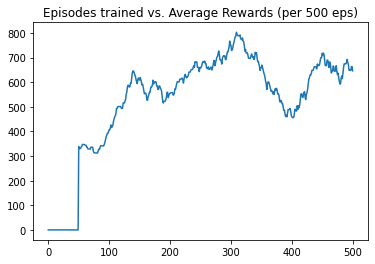

In [7]:
def run(training_mode, pretrained):
   
    env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
    env = make_env(env)  # Wraps the environment so that frames are grayscale 
    observation_space = env.observation_space.shape
    action_space = env.action_space.n
    agent = DQNAgent(state_space=observation_space,
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=32,
                     gamma=0.90,
                     lr=0.00025,
                     dropout=0.,
                     exploration_max=1.0,
                     exploration_min=0.02,
                     exploration_decay=0.99,
                     double_dq=False,
                     dq=True
                     pretrained=pretrained)
    
    num_episodes = 500
    env.reset()
    total_rewards = []
    
    for ep_num in tqdm(range(num_episodes)):
        state = env.reset()
        state = torch.Tensor([state])
        total_reward = 0
        steps = 0
        while True:
            if not training_mode:
                show_state(env, ep_num)
            action = agent.act(state)
            steps += 1
            
            state_next, reward, terminal, info = env.step(int(action[0]))
            total_reward += reward
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)
            
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            if training_mode:
                agent.remember(state, action, reward, state_next, terminal)
                agent.experience_replay()
            
            state = state_next
            if terminal:
                break
        
        total_rewards.append(total_reward)

        print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
        num_episodes += 1      
    
    if training_mode:
        with open("ending_position.pkl", "wb") as f:
            pickle.dump(agent.ending_position, f)
        with open("num_in_queue.pkl", "wb") as f:
            pickle.dump(agent.num_in_queue, f)
        with open("total_rewards.pkl", "wb") as f:
            pickle.dump(total_rewards, f)
        if agent.double_dq:
            torch.save(agent.local_net.state_dict(), "dq1.pt")
            torch.save(agent.target_net.state_dict(), "dq2.pt")
        else:
            torch.save(agent.dqn.state_dict(), "dq.pt")  
        torch.save(agent.STATE_MEM,  "STATE_MEM.pt")
        torch.save(agent.ACTION_MEM, "ACTION_MEM.pt")
        torch.save(agent.REWARD_MEM, "REWARD_MEM.pt")
        torch.save(agent.STATE2_MEM, "STATE2_MEM.pt")
        torch.save(agent.DONE_MEM,   "DONE_MEM.pt")
    
    env.close()
    
    if num_episodes >= 500:
        plt.title("Episodes trained vs. Average Rewards (per 500 eps)")
        plt.plot([0 for _ in range(50)] + 
                 np.convolve(total_rewards, np.ones((50,))/50, mode="valid").tolist())
        plt.show()

run(training_mode=True, pretrained=False)